In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='paper')
import numpy as np
from textwrap import wrap
from util import color_list,linestyle_list

In [2]:
save_path="/data2/lichenni/ns3"
file2matrix = {
        '../../workload/spatials/cluster_a.json': 'Traffic Matrix A',
        '../../workload/spatials/cluster_b.json': 'Traffic Matrix B',
        '../../workload/spatials/cluster_c.json': 'Traffic Matrix C',
    }
file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }

P99_PERCENTILE_LIST = np.arange(1, 101, 1)

MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

In [85]:
# 30% load
N_FLOWS=500*100*4
N_FLOWS_PER_PATH=400
N_FLOW_THRESHOLD = [1, 0, 0, 0]
worst_low_id=4
# mlsys_dir="mlsys_0114_const_bt10"
mlsys_dir="mlsys"
# mlsys_dir="mlsys_bdp_bt1"
mix_dir = f'../data/{worst_low_id}'
# Accuracy metrics
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_mlsys = [[] for _ in range(n_size_bucket_list_output)]

n_freq_list=[]
n_flow_list=[]
sizes=df_pmn_m['size']

# mix_dir = f'../data_test/{worst_low_id}'
path_idx=0
while os.path.exists(f'{mix_dir}/{mlsys_dir}/{path_idx}/fct_mlsys.txt'):
    with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
        lines = file.readlines()
        data=lines[0].strip().split(",")
        n_freq_list.append(int(data[-1]))
        
        flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
        size_list=[sizes[flowid] for flowid in flowid_list]
        
        n_links=len(data[0].split("|"))-1
        tmp=np.digitize(size_list, bin_size_list)
        # tmp=np.digitize(size_list, bin_size_dict[n_links])
        # Count occurrences of each bin index
        bin_counts = np.zeros(n_size_bucket_list_output)
        for bin_idx in tmp:
            bin_counts[bin_idx]+=1
        # n_flow_list.append(bin_counts>=N_FLOW_THRESHOLD)
        n_flow_list.append(bin_counts)
    path_idx+=1
n_flow_list=np.array(n_flow_list)
# print("n_flow_list: ",n_flow_list.shape)
n_flow_list_sum=n_flow_list.sum(axis=0)
# print("n_flow_list_sum: ",n_flow_list_sum)

with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
    lines = file.readlines()
    lines=lines[1:]
    for line_idx,line in enumerate(lines):
        data=line.strip().split(",")
        data = [float(value) for value in data]
        n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
        
        # prop_tmp=n_flow_list[line_idx//n_size_bucket_list_output]/np.sum(n_flow_list[line_idx//n_size_bucket_list_output])
        # num_tmp=int(N_FLOWS_PER_PATH*prop_tmp[line_idx%n_size_bucket_list_output])
        # data_sampled=np.random.choice(data,num_tmp,replace=True)
        # for _ in range(n_freq):
        #     df_mlsys[line_idx%n_size_bucket_list_output].extend(data_sampled)
        if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD[line_idx%n_size_bucket_list_output]:
            for _ in range(n_freq):
                df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
        # else:
        #     print("skip: ",data[0],data[-1])
df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]

sizes=df_ns3['size']
bin=np.digitize(sizes, bin_size_list)

bin_counts = np.bincount(bin)
total_count = np.sum(bin_counts)
# # Calculate the ratio for each bucket
bucket_ratios = bin_counts / total_count
print("bucket_ratios: ",bucket_ratios)
bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
print("bucket_ratios_sampled: ",bucket_ratios_sampled)
            
df_mlsys_bucket=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
print("df_mlsys_bucket: ",df_mlsys_bucket)
# df_mlsys_p99=np.sum(np.multiply(df_mlsys_bucket.T, bucket_ratios_sampled).T,axis=0)
df_mlsys_total=[]
for i in range(len(df_mlsys)):
    df_mlsys_total.extend(df_mlsys[i])
    # n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
    # df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
df_mlsys_p99=np.percentile(df_mlsys_total,99)

sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
sldn_ns3_p99=np.percentile(sldn_ns3,99)
sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)

print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," df_mlsys: ", df_mlsys_p99)
error=(sldn_pmn_m_p99-sldn_ns3_p99)/sldn_ns3_p99
error_mlsys=(df_mlsys_p99-sldn_ns3_p99)/sldn_ns3_p99

# assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]
print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}, df_mlsys: {df_mlsys_shape}")
# assert df_ns3.shape[0]==df_pmn_m.shape[0]

bucket_ratios:  [0.35756308 0.44401419 0.08893713 0.1094856 ]
bucket_ratios_sampled:  [0.325      0.49038462 0.09615385 0.08846154]
df_mlsys_bucket:  [1.94506393 2.09630433 2.42514741 2.809384  ]
sldn_ns3:  1.945345998459986  sldn_pmn_m:  1.9698740118844478  df_mlsys:  2.382063
df_ns3: 6831410, df_pmn_m: 6831534, df_mlsys: [50000, 50000, 50000, 50000]


In [3]:
# 70% load
N_FLOWS=500*100*4
N_FLOWS_PER_PATH=400
N_FLOW_THRESHOLD = [1, 1, 0, 0]
worst_low_id=2
# mlsys_dir="mlsys_0114_const_bt10"
mlsys_dir="mlsys"
# mlsys_dir="mlsys_bdp_bt1"
mix_dir = f'../data/{worst_low_id}'
# Accuracy metrics
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_mlsys = [[] for _ in range(n_size_bucket_list_output)]

n_freq_list=[]
n_flow_list=[]
sizes=df_pmn_m['size']

# mix_dir = f'../data_test/{worst_low_id}'
path_idx=0
while os.path.exists(f'{mix_dir}/{mlsys_dir}/{path_idx}/fct_mlsys.txt'):
    with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
        lines = file.readlines()
        data=lines[0].strip().split(",")
        n_freq_list.append(int(data[-1]))
        
        flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
        size_list=[sizes[flowid] for flowid in flowid_list]
        
        n_links=len(data[0].split("|"))-1
        tmp=np.digitize(size_list, bin_size_list)
        # tmp=np.digitize(size_list, bin_size_dict[n_links])
        # Count occurrences of each bin index
        bin_counts = np.zeros(n_size_bucket_list_output)
        for bin_idx in tmp:
            bin_counts[bin_idx]+=1
        # n_flow_list.append(bin_counts>=N_FLOW_THRESHOLD)
        n_flow_list.append(bin_counts)
    path_idx+=1
n_flow_list=np.array(n_flow_list)
# print("n_flow_list: ",n_flow_list.shape)
n_flow_list_sum=n_flow_list.sum(axis=0)
# print("n_flow_list_sum: ",n_flow_list_sum)

with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
    lines = file.readlines()
    lines=lines[1:]
    for line_idx,line in enumerate(lines):
        data=line.strip().split(",")
        data = [float(value) for value in data]
        n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
        
        # prop_tmp=n_flow_list[line_idx//n_size_bucket_list_output]/np.sum(n_flow_list[line_idx//n_size_bucket_list_output])
        # num_tmp=int(N_FLOWS_PER_PATH*prop_tmp[line_idx%n_size_bucket_list_output])
        # data_sampled=np.random.choice(data,num_tmp,replace=True)
        # for _ in range(n_freq):
        #     df_mlsys[line_idx%n_size_bucket_list_output].extend(data_sampled)
        if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD[line_idx%n_size_bucket_list_output]:
            for _ in range(n_freq):
                df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
        # else:
        #     print("skip: ",data[0],data[-1])
df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]

sizes=df_ns3['size']
bin=np.digitize(sizes, bin_size_list)

bin_counts = np.bincount(bin)
total_count = np.sum(bin_counts)
# # Calculate the ratio for each bucket
bucket_ratios = bin_counts / total_count
print("bucket_ratios: ",bucket_ratios)
bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
print("bucket_ratios_sampled: ",bucket_ratios_sampled)
            
df_mlsys_bucket=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
print("df_mlsys_bucket: ",df_mlsys_bucket)
# df_mlsys_p99=np.sum(np.multiply(df_mlsys_bucket.T, bucket_ratios_sampled).T,axis=0)
df_mlsys_total=[]
for i in range(len(df_mlsys)):
    df_mlsys_total.extend(df_mlsys[i])
    # n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
    # df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
df_mlsys_p99=np.percentile(df_mlsys_total,99)

sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
sldn_ns3_p99=np.percentile(sldn_ns3,99)
sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)

print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," df_mlsys: ", df_mlsys_p99)
error=(sldn_pmn_m_p99-sldn_ns3_p99)/sldn_ns3_p99
error_mlsys=(df_mlsys_p99-sldn_ns3_p99)/sldn_ns3_p99

# assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]
print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}, df_mlsys: {df_mlsys_shape}")
# assert df_ns3.shape[0]==df_pmn_m.shape[0]

bucket_ratios:  [0.35766685 0.44398597 0.08891288 0.1094343 ]
bucket_ratios_sampled:  [0.38974359 0.39487179 0.0991453  0.11623932]
df_mlsys_bucket:  [2.64836    2.63056778 3.05112121 3.534961  ]
sldn_ns3:  3.4196535635818113  sldn_pmn_m:  4.139792027693596  df_mlsys:  3.053123090000001
df_ns3: 31646640, df_pmn_m: 31647249, df_mlsys: [21300, 21300, 50000, 50000]


0:  1.0
1:  1.0
2:  1.0
3:  1.0


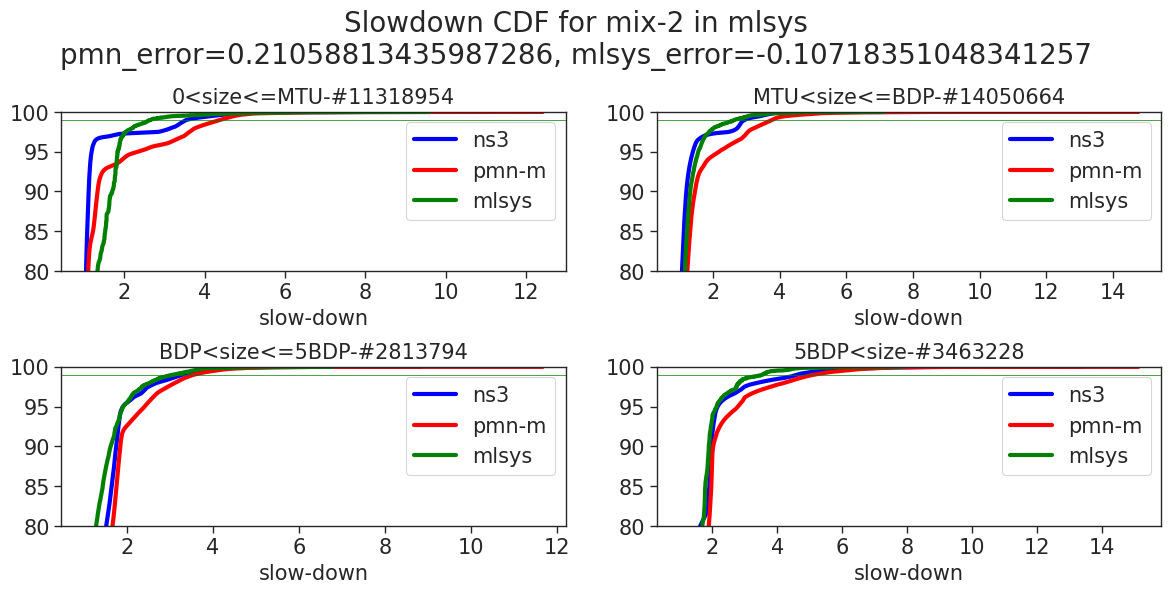

In [104]:
_fontsize=15
plt.figure(0,figsize=(12, 6))
bin_ns3=np.digitize(df_ns3['size'], bin_size_list)
bin_pmn_m=np.digitize(df_pmn_m['size'], bin_size_list)
plt.suptitle(f"Slowdown CDF for mix-{worst_low_id} in {mlsys_dir}\npmn_error={error}, mlsys_error={error_mlsys}",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin_pmn_m==i, sldn_pmn_m)
    tmp_sldn_mlsys=df_mlsys[i]
    print(f"{i}: ", min(tmp_sldn_mlsys))
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(tmp_sldn_ns3)}",fontsize=_fontsize)
    plt.plot(np.sort(tmp_sldn_ns3), (np.arange(len(tmp_sldn_ns3))/len(tmp_sldn_ns3)*100), label='ns3', color='blue', linewidth=3)
    plt.plot(np.sort(tmp_sldn_pmn_m), (np.arange(len(tmp_sldn_pmn_m))/len(tmp_sldn_pmn_m)*100), label='pmn-m', color='red', linewidth=3)
    plt.plot(np.sort(tmp_sldn_mlsys), (np.arange(len(tmp_sldn_mlsys))/len(tmp_sldn_mlsys)*100), label='mlsys', color='green', linewidth=3)
    # plt.plot(np.sort(tmp_sldn_flowsim), (np.arange(len(tmp_sldn_flowsim))/len(tmp_sldn_flowsim)*100), label='flowsim', color='orange', linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    plt.ylim(80, 100)
    plt.xlabel('slow-down', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()

In [4]:
# 50% load
N_FLOWS=500*100*4
N_FLOWS_PER_PATH=400
N_FLOW_THRESHOLD = [0, 0, 0, 0]
worst_low_id=1
# mlsys_dir="mlsys_0114_const_bt10"
mlsys_dir="mlsys-new_e426"
mix_dir = f'../data/{worst_low_id}'
# Accuracy metrics
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_mlsys = [[] for _ in range(n_size_bucket_list_output)]

n_freq_list=[]
n_flow_list=[]
sizes=df_pmn_m['size']

# mix_dir = f'../data_test/{worst_low_id}'
path_idx=0
while os.path.exists(f'{mix_dir}/{mlsys_dir}/{path_idx}/fct_mlsys.txt'):
    with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
        lines = file.readlines()
        data=lines[0].strip().split(",")
        n_freq_list.append(int(data[-1]))
        
        flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
        size_list=[sizes[flowid] for flowid in flowid_list]
        
        n_links=len(data[0].split("|"))-1
        tmp=np.digitize(size_list, bin_size_list)
        # tmp=np.digitize(size_list, bin_size_dict[n_links])
        # Count occurrences of each bin index
        bin_counts = np.zeros(n_size_bucket_list_output)
        for bin_idx in tmp:
            bin_counts[bin_idx]+=1
        # n_flow_list.append(bin_counts>=N_FLOW_THRESHOLD)
        n_flow_list.append(bin_counts)
    path_idx+=1
n_flow_list=np.array(n_flow_list)
# print("n_flow_list: ",n_flow_list.shape)
n_flow_list_sum=n_flow_list.sum(axis=0)
# print("n_flow_list_sum: ",n_flow_list_sum)

with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
    lines = file.readlines()
    lines=lines[1:]
    for line_idx,line in enumerate(lines):
        data=line.strip().split(",")
        data = [float(value) for value in data]
        n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
        
        # prop_tmp=n_flow_list[line_idx//n_size_bucket_list_output]/np.sum(n_flow_list[line_idx//n_size_bucket_list_output])
        # num_tmp=int(N_FLOWS_PER_PATH*prop_tmp[line_idx%n_size_bucket_list_output])
        # data_sampled=np.random.choice(data,num_tmp,replace=True)
        # for _ in range(n_freq):
        #     df_mlsys[line_idx%n_size_bucket_list_output].extend(data_sampled)
        if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD[line_idx%n_size_bucket_list_output]:
            for _ in range(n_freq):
                df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
        # else:
        #     print("skip: ",data[0],data[-1])
df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]

sizes=df_ns3['size']
bin=np.digitize(sizes, bin_size_list)

bin_counts = np.bincount(bin)
total_count = np.sum(bin_counts)
# # Calculate the ratio for each bucket
bucket_ratios = bin_counts / total_count
print("bucket_ratios: ",bucket_ratios)
bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
print("bucket_ratios_sampled: ",bucket_ratios_sampled)
            
df_mlsys_bucket=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
print("df_mlsys_bucket: ",df_mlsys_bucket)
# df_mlsys_p99=np.sum(np.multiply(df_mlsys_bucket.T, bucket_ratios_sampled).T,axis=0)
df_mlsys_total=[]
for i in range(len(df_mlsys)):
    df_mlsys_total.extend(df_mlsys[i])
    # n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
    # df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
df_mlsys_p99=np.percentile(df_mlsys_total,99)

sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
sldn_ns3_p99=np.percentile(sldn_ns3,99)
sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)

print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," df_mlsys: ", df_mlsys_p99)
error=(sldn_pmn_m_p99-sldn_ns3_p99)/sldn_ns3_p99
error_mlsys=(df_mlsys_p99-sldn_ns3_p99)/sldn_ns3_p99

# assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]
print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}, df_mlsys: {df_mlsys_shape}")
# assert df_ns3.shape[0]==df_pmn_m.shape[0]

bucket_ratios:  [0.3577588  0.44385298 0.08892915 0.10945907]
bucket_ratios_sampled:  [0.36346516 0.41242938 0.09039548 0.13370998]
df_mlsys_bucket:  [2.10433768 1.55608232 2.23288    2.773338  ]
sldn_ns3:  2.8153335339189587  sldn_pmn_m:  3.0644250924464442  df_mlsys:  2.2823036900000044
df_ns3: 11351430, df_pmn_m: 11351638, df_mlsys: [50000, 50000, 50000, 50000]


0:  1.0
1:  1.0
2:  1.0
3:  1.0


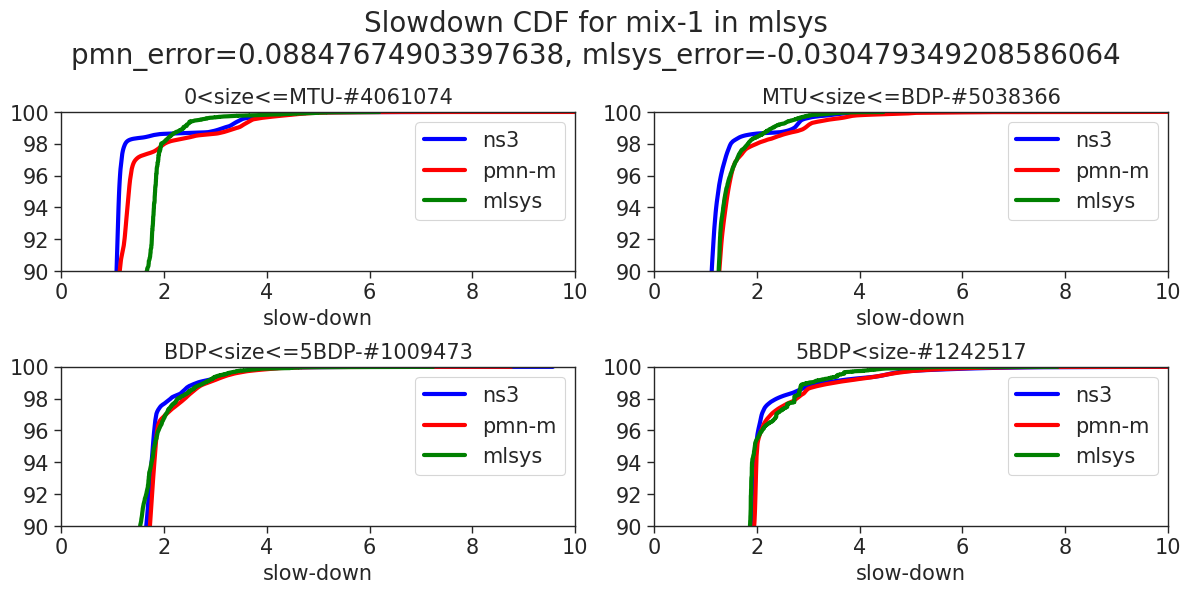

In [97]:
_fontsize=15
plt.figure(0,figsize=(12, 6))
plt.suptitle(f"Slowdown CDF for mix-{worst_low_id} in {mlsys_dir}\npmn_error={error}, mlsys_error={error_mlsys}",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
bin_ns3=np.digitize(df_ns3['size'], bin_size_list)
bin_pmn_m=np.digitize(df_pmn_m['size'], bin_size_list)
for i in range(len(labels)):
    tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin_pmn_m==i, sldn_pmn_m)
    tmp_sldn_mlsys=df_mlsys[i]
    print(f"{i}: ", min(tmp_sldn_mlsys))
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(tmp_sldn_ns3)}",fontsize=_fontsize)
    plt.plot(np.sort(tmp_sldn_ns3), (np.arange(len(tmp_sldn_ns3))/len(tmp_sldn_ns3)*100), label='ns3', color='blue', linewidth=3)
    plt.plot(np.sort(tmp_sldn_pmn_m), (np.arange(len(tmp_sldn_pmn_m))/len(tmp_sldn_pmn_m)*100), label='pmn-m', color='red', linewidth=3)
    plt.plot(np.sort(tmp_sldn_mlsys), (np.arange(len(tmp_sldn_mlsys))/len(tmp_sldn_mlsys)*100), label='mlsys', color='green', linewidth=3)
    # plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    plt.ylim(90, 100)
    plt.xlim(0,10)
    plt.xlabel('slow-down', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()

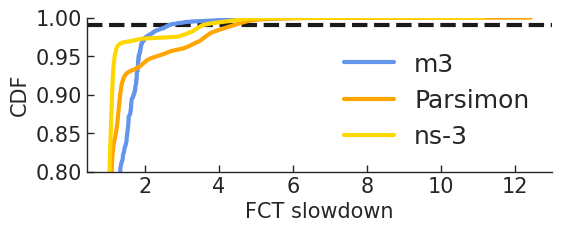

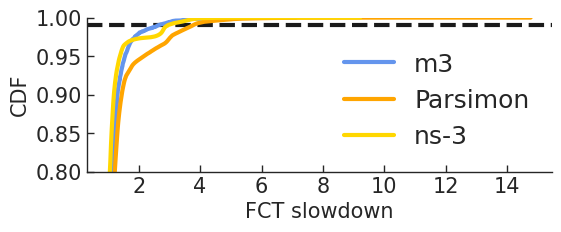

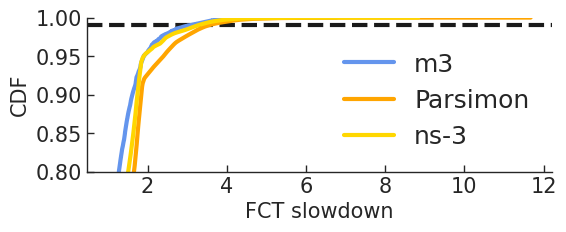

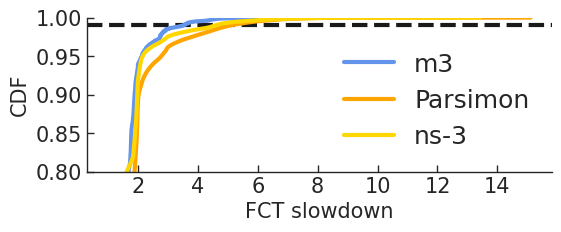

In [4]:
def plot_cdf(
    raw_data,
    file_name,
    linelabels,
    x_label,
    y_label="CDF",
    log_switch=False,
    rotate_xaxis=False,
    ylim_low=0,
    xlim=None,
    xlim_bottom=None,
    fontsize=15,
    legend_font=15,
    loc=2,
    title=None,
    enable_abs=False,
    group_size=1,
):
    _fontsize = fontsize
    fig = plt.figure(figsize=(6, 2.))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.axhline(0.99, color='k', linewidth=3, linestyle='--',zorder=0)
    
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    if log_switch:
        ax.set_xscale("log")

    plt.ylabel(y_label, fontsize=_fontsize)
    plt.xlabel(x_label, fontsize=_fontsize)
    linelabels = ["\n".join(wrap(l, 30)) for l in linelabels]
    for i in range(len(raw_data)):
        data = raw_data[i]
        data = data[~np.isnan(data)]
        if len(data) == 0:
            continue
        if enable_abs:
            data = abs(data)
        # data=random.sample(data,min(1e6,len(data)))
        data_size = len(data)
        # data=list(filter(lambda score: 0<=score < std_val, data))
        # Set bins edges
        data_set = sorted(set(data))
        bins = np.append(data_set, data_set[-1] + 1)

        # Use the histogram function to bin the data
        counts, bin_edges = np.histogram(data, bins=bins, density=False)

        counts = counts.astype(float) / data_size

        # Find the cdf
        cdf = np.cumsum(counts)

        # Plot the cdf
        if i < len(linelabels):
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                label=linelabels[i],
                linewidth=3,
            )
        else:
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                linewidth=3,
            )

    legend_properties = {"size": legend_font}
    plt.legend(
        prop=legend_properties,
        frameon=False,
        loc=loc,
    )

    plt.ylim((ylim_low, 1))
    if xlim_bottom:
        plt.xlim(left=xlim_bottom)
    if xlim:
        plt.xlim(right=xlim)
    # plt.tight_layout()
    # plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    # plt.grid(True)
    
    if rotate_xaxis:
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    if title:
        plt.title(title, fontsize=_fontsize - 5)
    if file_name:
        plt.savefig(file_name, bbox_inches="tight", pad_inches=0)

legend_list=['m3','Parsimon','ns-3']
bin_ns3=np.digitize(df_ns3['size'], bin_size_list)
bin_pmn_m=np.digitize(df_pmn_m['size'], bin_size_list)
for i in range(len(labels)):
    
    tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin_pmn_m==i, sldn_pmn_m)
    tmp_sldn_mlsys=np.array(df_mlsys[i])
    
    plot_data=[tmp_sldn_mlsys,tmp_sldn_pmn_m,tmp_sldn_ns3]
    plot_cdf(plot_data,f'figs/eva_large_scale_{i}.pdf',legend_list,'FCT slowdown',legend_font=18,group_size=3,loc=4,rotate_xaxis=False,ylim_low=0.8,log_switch=False)
    

sldn_ns3:  2.8172502875523078  sldn_pmn_m: 


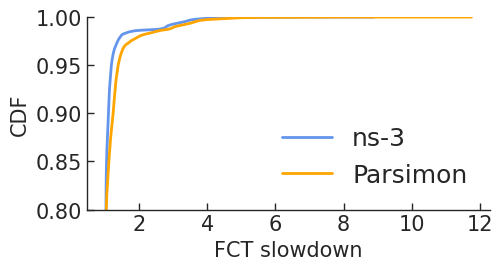

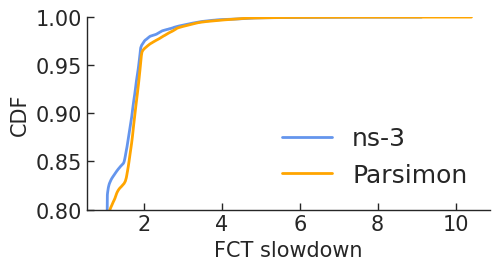

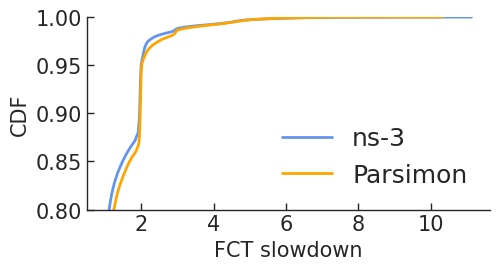

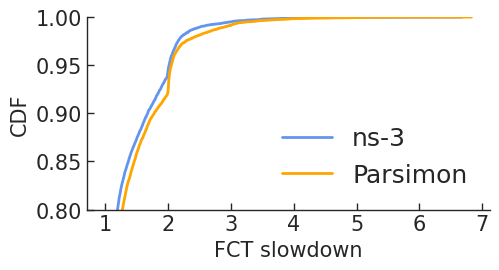

In [40]:
# 50% load
worst_low_id=1
mlsys_dir="mlsys"
mix_dir = f'../data/{worst_low_id}'
# df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
# df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv').sample(n=2_000_000)
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv').sample(n=2_000_000)


bin_ns3=np.digitize(df_ns3['size'], [10*MTU,100*MTU,1000*MTU])
bin_pmn_m=np.digitize(df_pmn_m['size'], [10*MTU,100*MTU,1000*MTU])

sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
sldn_ns3_p99=np.percentile(sldn_ns3,99)
sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)

print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ")

legend_list=['ns-3','Parsimon']
for i in range(len(labels)):
    tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin_pmn_m==i, sldn_pmn_m)
    
    plot_data=[tmp_sldn_ns3,tmp_sldn_pmn_m]
    plot_cdf(plot_data,None,legend_list,'FCT slowdown',legend_font=18,group_size=3,loc=4,rotate_xaxis=False,ylim_low=0.8,log_switch=False)